In [1]:
%config Completer.use_jedi=False

In [2]:
import random
import os

import keras
import numpy as np
from keras.callbacks import LambdaCallback
from keras.models import Input,Model,load_model
from keras.layers import LSTM,Dropout,Dense
from keras.optimizers import adam_v2

**sorted() 函数**

**sorted(iterable, cmp=None, key=None, reverse=False)**
- iterable -- 可迭代对象。
- cmp -- 比较的函数，这个具有两个参数，参数的值都是从可迭代对象中取出，此函数必须遵守的规则为，大于则返回1，小于则返回-1，等于则返回0。
- key -- 主要是用来进行比较的元素，只有一个参数，具体的函数的参数就是取自于可迭代对象中，指定可迭代对象中的一个元素来进行排序。
- reverse -- 排序规则，reverse = True 降序 ， reverse = False 升序（默认）。

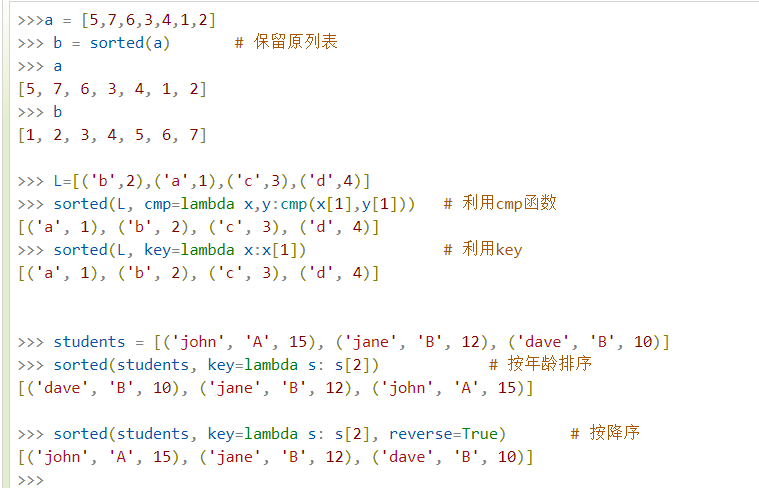

**zip() 函数**

**zip([iterable, ...])**
- iterabl -- 一个或多个迭代器

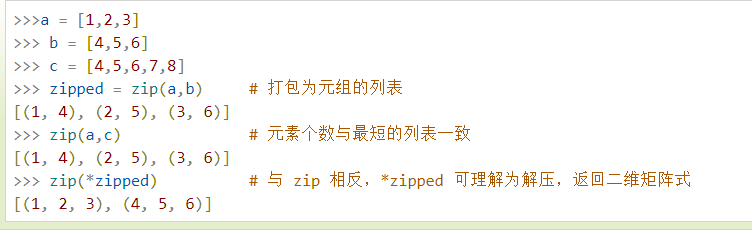

**dict() 函数**
```class dict(**kwarg)
class dict(mapping, **kwarg)
class dict(iterable, **kwarg)
```
- \**kwargs -- 关键字
- mapping -- 元素的容器。
- iterable -- 可迭代对象

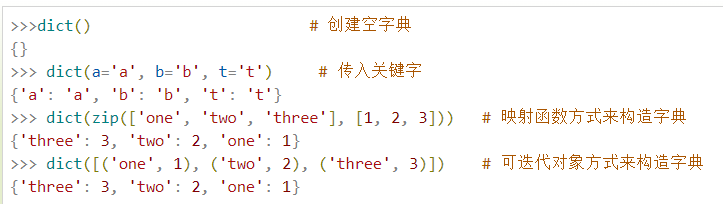

In [3]:
def preprocess_file():
    # 预料文本内容
    files_content = ''
    protry_file = './data/poetry_demo.txt'
    with open (protry_file,'r',encoding='utf-8') as f:
        for line in f:
            x = line.strip()+"]"
            x = x.split(":")[1]
            if len(x) <= 5:
                continue
            if x[5] == '，':
                files_content +=x
    
    # print(files_content)
    words = sorted(list(files_content))
    # print(words)
    counted_words= {}
    
    for word in words:
        if word in counted_words:
            counted_words[word] +=1
        else:
            counted_words[word] =1
    # print(counted_words.keys())
    
    # 去掉低频的字
    erase = []
    for key in counted_words:
        if counted_words[key] <=2:
            erase.append(key)
    for key in erase:
        del counted_words[key]
    # print(counted_words.keys())
    wordPairs = sorted(counted_words.items(), key=lambda x:-x[1]) 
    
    words,_ = zip(*wordPairs)
    # print(words)
    words +=(" ",)
    # print(words)
    # worid 到id的映射
    word2num = dict((c,i) for i,c in enumerate(words))
    num2word = dict((i,c) for i,c in enumerate(words))
    word2numF = lambda x:word2num.get(x,len(words)-1)
    
    return word2numF,num2word,words,files_content

In [4]:
word2numF_01,num2word_01,words_01,files_content_01 = preprocess_file()

In [5]:
len(files_content_01.split(']'))

28

In [6]:
class PoetryModel(object):
    def __init__(self):
        self.model = None
        self.do_train = True
        self.loaded_model = True
        self.max_len = 6
        self.batch_size = 32
        self.learning_rate = 0.001

        # 文本预处理
        self.word2numF, self.num2word, self.words, self.files_content = preprocess_file()

        # 诗list
        self.poems = self.files_content.split(']')

        # 诗总数量
        self.poems_num = len(self.poems)-1
        print(self.poems_num)

        self.model_path = './out/poetry_model.h5'
        self.out_path ='./out'
        if not os.path.exists(self.out_path):
            os.mkdir(self.out_path)
        # 如果模型文件存在则直接加载模型，否则开始训练
        if os.path.exists(self.model_path) and self.loaded_model:
            self.model = load_model(self.model_path)
        else:
            self.train()

    def build_model(self):
        ''' 建立模型 '''
        print("建立模型")

        input_tensor = Input(shape=(self.max_len, len(self.words)))
        lstm = LSTM(512, return_sequences=True)(input_tensor)
        dropout = Dropout(0.6)(lstm)
        lstm = LSTM(256)(dropout)
        dropout = Dropout(0.6)(lstm)
        dense = Dense(len(self.words), activation='softmax')(dropout)
        self.model = Model(inputs=input_tensor, outputs=dense)
        optimizer = adam_v2.Adam(lr=self.learning_rate)
        self.model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    def sample(self, preds, temperature=1.0):
        '''
        当temperature=1.0时，模型输出正常
        当temperature=0.5时，模型输出比较open
        当temperature=1.5时，模型输出比较保守
        在训练的过程中可以看到temperature不同，结果也不同
        就是一个概率分布变换的问题，保守的时候概率大的值变得更大，选择的可能性也更大
        '''
        preds = np.asarray(preds).astype('float64')
        exp_preds = np.power(preds, 1. / temperature)
        preds = exp_preds / np.sum(exp_preds)
        pro = np.random.choice(range(len(preds)), 1, p=preds)
        return int(pro.squeeze())

    def generate_sample_result(self, epoch, logs):
        ''' 训练过程中 每4个epoch打印当前学习情况 '''
        if epoch % 4 != 0:
            return
        with open('./out/out.txt', 'a', encoding='utf-8') as f:
            f.write('=================epoch{}================\n'.format(epoch))

        print('\n=================epoch{}================\n'.format(epoch))
        for diversity in [0.7, 1.0, 1.3]:
            print('\n=================diversity{}================\n'.format(diversity))
            generate = self.predict_random(temperature=diversity)
            print(generate)

            # 训练时预测结果 写入txt
            with open('./out/out.txt', 'a', encoding='utf-8') as f:
                f.write(str(generate)+'\n')

    def predict_random(self, temperature=1):
        ''' 随机从库中选取一句开头的诗句 生成五言绝句 '''
        if not self.model:
            return

        index = random.randint(0, self.poems_num)
        print(index)
        sentence = self.poems[index][:self.max_len]
        generate = self.predict_sen(sentence, temperature=temperature)
        return generate

    def predict_first(self, char, temperature=1):
        ''' 根据给出的首字 生成五言绝句 '''
        if not self.model:
            print('model not loaded')
            return

        index = random.randint(0, self.poems_num)
        # 随机选择一首诗的最后max_len字符+首个文字作为初始输入
        sentence = self.poems[index][1 - self.max_len:] + char
        print('first line', sentence)
        generate = str(char)
        # 直接预测后面的23个字符
        generate += self._preds(sentence, length=23, temperature=temperature)
        return generate

    def predict_sen(self, text, temperature=1):
        ''' 根据给出的前 max_len个字，生成诗句 '''
        if not self.model:
            return

        max_len = self.max_len
        if len(text) < max_len:
            print('输入文案长度不能小于', max_len)
            return

        sentence = text[-max_len:]
        print("第一行:", sentence)
        generate = str(sentence)
        generate += self._preds(sentence, length=24 - max_len, temperature=temperature)
        return generate

    def predict_hide(self, text, temperature=1):
        ''' 根据给出的4个字，生成藏头诗五言拒绝 '''
        if not self.model:
            return
        if len(text) != 4:
            return

        index = random.randint(0, self.poems_num)
        # 随机选一首诗的最后max_len字符+给出的首个文字作为初始输入
        sentence = self.poems[index][1 - self.max_len:] + text[0]
        generate = str(text[0])
        print("第一行：", sentence)

        for i in range(5):
            next_char = self._pred(sentence, temperature)
            sentence = sentence[1:] +next_char
            generate += next_char

        for i in range(3):
            generate += text[i + 1]
            sentence = sentence[1:] + text[i + 1]
            for i in range(5):
                next_char = self._pred(sentence, temperature)
                sentence = sentence[1:] +next_char
                generate += next_char

        return generate

    def _preds(self, sentence, length=23, temperature=1):
        '''
        sentence:预测输入值
        length:预测出的字符串长度
        '''
        sentence = sentence[:self.max_len]
        generate = ''
        for i in range(length):
            pred = self._pred(sentence, temperature)
            generate += pred
            sentence = sentence[1:] + pred
        return generate

    def _pred(self, sentence, temperature=1):
        if len(sentence) < self.max_len:
            return
        sentence = sentence[-self.max_len:]
        x_pred = np.zeros((1, self.max_len, len(self.words)))
        for t, char in enumerate(sentence):
            x_pred[0, t, self.word2numF(char)] = 1.
        preds = self.model.predict(x_pred, verbose=0)[0]
        next_index = self.sample(preds, temperature=temperature)
        next_char = self.num2word[next_index]

        return next_char

    def data_generator(self):
        ''' 生成器 生成数据 '''
        i = 0
        while 1:
            x = self.files_content[i:i + self.max_len]
            y = self.files_content[i + self.max_len]

            if ']' in x or ']' in y:
                i += 1
                continue

            y_vec = np.zeros(
                shape=(1, len(self.words)),
                dtype=np.bool
            )
            y_vec[0, self.word2numF(y)] = 1.0

            x_vec = np.zeros(
                shape=(1, self.max_len, len(self.words)),
                dtype=np.bool
            )

            for t, char in enumerate(x):
                x_vec[0, t, self.word2numF(char)] = 1.0

            yield x_vec, y_vec
            i += 1

    def train(self):
        ''' 训练模型 '''
        print("training")
        number_of_epoch = len(self.files_content) - (self.max_len + 1) * self.poems_num
        number_of_epoch /= self.batch_size
        number_of_epoch = int(number_of_epoch / 1.5)
        print('epochs=', number_of_epoch)
        print('poems=', self.poems_num)
        print('len(self.files_content)=', len(self.files_content))

        if not self.model:
            self.build_model()

        self.model.fit_generator(
            generator=self.data_generator(),
            verbose=True,
            steps_per_epoch=self.batch_size,
            epochs=number_of_epoch,
            callbacks=[
                keras.callbacks.ModelCheckpoint(self.model_path, save_weights_only=False),
                LambdaCallback(on_batch_end=self.generate_sample_result)
            ]
        )

In [7]:
model = PoetryModel()

27
training
epochs= 55
poems= 27
len(self.files_content)= 2871
建立模型


C:\Users\Administrator\Envs\py3.6.5_tf2\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")
C:\Users\Administrator\Envs\py3.6.5_tf2\lib\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/55
 1/32 [..............................] - ETA: 1:14 - loss: 5.7317 - accuracy: 0.0000e+00
=================epoch0================


=================diversity0.7================

6
第一行: 山亭秋色满，
山亭秋色满，鸟秋七高开夕龙悦燕兹翠反易山岂端山七

=================diversity1.0================

27
输入文案长度不能小于 6
None

=================diversity1.3================

19
第一行: 碧原开雾隰，
碧原开雾隰，景氛书人。易舆苔壮七沙动除昔满岫武危
 2/32 [>.............................] - ETA: 48s - loss: 5.7283 - accuracy: 0.0000e+00 
=================epoch4================


=================diversity0.7================

8
第一行: 塞外悲风切，
塞外悲风切，可处丹转所怀凝马动玄波剑何辉箭镜提汉

=================diversity1.0================

0
第一行: 寒随穷律变，
寒随穷律变，鸟七弓林火禽眺知桂道气海荒流知。天人

=================diversity1.3================

15
第一行: 慨然抚长剑，
慨然抚长剑，尘风树衣苑菊除绿秋前光夕筵深静霞劳七
 6/32 [====>.........................] - ETA: 17s - loss: 5.7234 - accuracy: 0.0000e+00
=================epoch8================


=================diversity0.7================

16
第一行: 崤函称地险，
崤函称地险，时平渭千阳八心还飘难兰景不岫云残道池

=====

In [8]:
for i in range(3):
    sen=model.predict_hide('争云日夏')
    print(sen)

第一行： 空燕不窥。争
争    ，云游开阳星。日  汉林，夏初 ，风。
第一行： 必襄城外。争
争庭箭。 ，云舆 ， 。日  。 ，夏一苔， 。
第一行： 尺轮光暮。争
争月功迹 ，云 有飞 。日 乃凤 ，夏所 夕兹。
